In [3]:
import deepchem as dc
from rdkit import Chem

In [6]:
smiles = ["C1CCCCC1", "O1CCOCC1"]  # cyclohexane and dioxane
mols = [Chem.MolFromSmiles(smile) for smile in smiles]
feat = dc.feat.CircularFingerprint(size=1024)
arr = feat.featurize(mols)
print(type(arr))
arr

<class 'numpy.ndarray'>


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
print(len(arr[0]))

1024


# Load and save list of building blocks

In [20]:
import duckdb
import pandas as pd

train_path = "leash-BELKA/train.parquet"
test_path = "leash-BELKA/test.parquet"

In [10]:
def get_building_blocks(bb_name, file_path):
    con = duckdb.connect()

    # Query using DuckDB
    sql_stm = f"SELECT DISTINCT({bb_name}) FROM parquet_scan('{file_path}')"
    result = con.execute(sql_stm)

    bb_smiles = []
    for bb in result.fetchall():
        bb_smiles.append(bb[0])

    return bb_smiles

In [11]:
bb1_smiles_train = get_building_blocks(
    bb_name="buildingblock1_smiles", file_path=train_path
)
bb2_smiles_train = get_building_blocks(
    bb_name="buildingblock2_smiles", file_path=train_path
)
bb3_smiles_train = get_building_blocks(
    bb_name="buildingblock3_smiles", file_path=train_path
)

print(f"No. BB1: {len(bb1_smiles_train)}")
print(f"No. BB2: {len(bb2_smiles_train)}")
print(f"No. BB3: {len(bb3_smiles_train)}")

No. BB1: 271
No. BB2: 693
No. BB3: 872


In [12]:
bb1_smiles_test = get_building_blocks(
    bb_name="buildingblock1_smiles", file_path=test_path
)
bb2_smiles_test = get_building_blocks(
    bb_name="buildingblock2_smiles", file_path=test_path
)
bb3_smiles_test = get_building_blocks(
    bb_name="buildingblock3_smiles", file_path=test_path
)

print(f"No. BB1: {len(bb1_smiles_test)}")
print(f"No. BB2: {len(bb2_smiles_test)}")
print(f"No. BB3: {len(bb3_smiles_test)}")

No. BB1: 341
No. BB2: 1140
No. BB3: 1389


In [14]:
# check overlap or not -> yes
overlap_train_set = bb1_smiles_train + bb2_smiles_train + bb3_smiles_train
print("Before:", len(overlap_train_set))
print("After:", len(set(overlap_train_set)))

Before: 1836
After: 1145


In [15]:
# check overlap or not -> yes
overlap_test_set = bb1_smiles_test + bb2_smiles_test + bb3_smiles_test
print("Before:", len(overlap_test_set))
print("After:", len(set(overlap_test_set)))

Before: 2870
After: 2110


In [17]:
# check train and test -> yes (35.17%)
overlap_all_set = list(set(overlap_train_set)) + list(set(overlap_test_set))
print("Before:", len(overlap_all_set))
print("After:", len(set(overlap_all_set)))

Before: 3255
After: 2110


In [26]:
# indexing all smiles
overlap_all_set = sorted(set(overlap_all_set))
pd_bb_smiles = pd.DataFrame(overlap_all_set)
pd_bb_smiles.columns = ["bb_smiles"]
pd_bb_smiles = pd_bb_smiles.reset_index()
print(pd_bb_smiles.shape)
pd_bb_smiles.head()

(2110, 2)


,index,bb_smiles
0,0,Br.Br.NCC1CCCN1c1cccnn1
1,1,Br.NCc1cccc(Br)n1
2,2,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O
3,3,C#CCN(C)CCCN
4,4,C#CCOc1ccc(CN)cc1.Cl


In [25]:
pd_bb_smiles.to_csv("featurized/all_bb_smiles.csv", index=False)

### Feature 1: Extended-connectivity fingerprints (ECFPs)

In [11]:
import deepchem as dc
from rdkit import Chem
import pandas as pd
import numpy as np

In [2]:
pd_bb_smiles = pd.read_csv("featurized/all_bb_smiles.csv")
print(pd_bb_smiles.shape)
pd_bb_smiles.head()

(2110, 2)


,index,bb_smiles
0,0,Br.Br.NCC1CCCN1c1cccnn1
1,1,Br.NCc1cccc(Br)n1
2,2,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O
3,3,C#CCN(C)CCCN
4,4,C#CCOc1ccc(CN)cc1.Cl


In [4]:
pd_bb_smiles["mols"] = pd_bb_smiles["bb_smiles"].apply(
    lambda smile: Chem.MolFromSmiles(smile)
)
pd_bb_smiles.head()

,index,bb_smiles,mols
0,0,Br.Br.NCC1CCCN1c1cccnn1,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...
1,1,Br.NCc1cccc(Br)n1,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...
2,2,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...
3,3,C#CCN(C)CCCN,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...
4,4,C#CCOc1ccc(CN)cc1.Cl,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...


In [7]:
feat = dc.feat.CircularFingerprint(size=1024)
pd_bb_smiles["f1_ecfp"] = pd_bb_smiles["mols"].apply(
    lambda mols: feat.featurize(mols)[0]
)
pd_bb_smiles.head()

[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerator
[14:41:35] DEPRECATION WARNING: please use MorganGenerat

,index,bb_smiles,mols,f1_ecfp
0,0,Br.Br.NCC1CCCN1c1cccnn1,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,Br.NCc1cccc(Br)n1,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,C#CCN(C)CCCN,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,C#CCOc1ccc(CN)cc1.Cl,<rdkit.Chem.rdchem.Mol object at 0x0000022A4E4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
pd_bb_smiles.loc[0, "f1_ecfp"]

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
# Create a new dataframe where each element in the array is split into its own column
ecfp_df = pd.DataFrame(pd_bb_smiles["f1_ecfp"].tolist(), index=pd_bb_smiles.index)

# Rename the columns with the desired format (f1_ecfp_1, f1_ecfp_2, ..., f1_ecfp_1024)
ecfp_df.columns = [f"f1_ecfp_{i+1}" for i in range(ecfp_df.shape[1])]

# Convert values to byte (uint8) type
ecfp_df = ecfp_df.astype(np.uint8)
ecfp_df = ecfp_df.reset_index()

print(ecfp_df.shape)
ecfp_df.head()

(2110, 1025)


,index,f1_ecfp_1,f1_ecfp_2,f1_ecfp_3,f1_ecfp_4,f1_ecfp_5,f1_ecfp_6,f1_ecfp_7,f1_ecfp_8,f1_ecfp_9,...,f1_ecfp_1015,f1_ecfp_1016,f1_ecfp_1017,f1_ecfp_1018,f1_ecfp_1019,f1_ecfp_1020,f1_ecfp_1021,f1_ecfp_1022,f1_ecfp_1023,f1_ecfp_1024
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# check coverage
ecfp_df.mean().sort_values(ascending=False)

index          1054.500000
f1_ecfp_357       0.856872
f1_ecfp_850       0.818483
f1_ecfp_727       0.623697
f1_ecfp_148       0.605213
                  ...     
f1_ecfp_29        0.000948
f1_ecfp_49        0.000948
f1_ecfp_90        0.000948
f1_ecfp_543       0.000474
f1_ecfp_451       0.000474
Length: 1025, dtype: float64

In [14]:
ecfp_df.to_csv("featurized/all_f1_ecfp.csv", index=False)

### Feature 2: Molecular Descriptors

In [2]:
import deepchem as dc
from rdkit import Chem
import pandas as pd
import numpy as np

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\predator\anaconda3\envs\polar_duckdb_benchmarks_gpu\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\predator\anaconda3\envs\polar_duckdb_benchmarks_gpu\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
pd_bb_smiles = pd.read_csv("featurized/all_bb_smiles.csv")
print(pd_bb_smiles.shape)
pd_bb_smiles.head()

(2110, 2)


,index,bb_smiles
0,0,Br.Br.NCC1CCCN1c1cccnn1
1,1,Br.NCc1cccc(Br)n1
2,2,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O
3,3,C#CCN(C)CCCN
4,4,C#CCOc1ccc(CN)cc1.Cl


In [4]:
pd_bb_smiles["mols"] = pd_bb_smiles["bb_smiles"].apply(
    lambda smile: Chem.MolFromSmiles(smile)
)
pd_bb_smiles.head()

,index,bb_smiles,mols
0,0,Br.Br.NCC1CCCN1c1cccnn1,<rdkit.Chem.rdchem.Mol object at 0x00000173176...
1,1,Br.NCc1cccc(Br)n1,<rdkit.Chem.rdchem.Mol object at 0x00000173176...
2,2,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x00000173176...
3,3,C#CCN(C)CCCN,<rdkit.Chem.rdchem.Mol object at 0x00000173176...
4,4,C#CCOc1ccc(CN)cc1.Cl,<rdkit.Chem.rdchem.Mol object at 0x00000173176...


In [7]:
mols = Chem.MolFromSmiles("Br.Br.NCC1CCCN1c1cccnn1")
feat = dc.feat.RDKitDescriptors()
arr = feat.featurize(mols)
len(arr[0])

[14:53:04] DEPRECATION WARNING: please use MorganGenerator
[14:53:04] DEPRECATION WARNING: please use MorganGenerator
[14:53:04] DEPRECATION WARNING: please use MorganGenerator


210

count    210.000000
mean      11.183089
std       45.255411
min       -2.354432
25%        0.000000
50%        0.000000
75%        4.282969
max      340.063000
dtype: float64

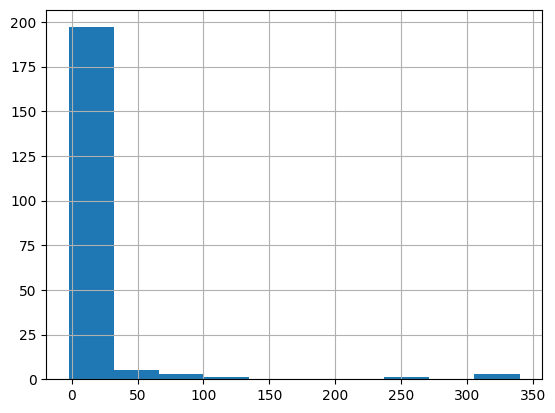

In [10]:
pd.Series(arr[0]).hist()
pd.Series(arr[0]).describe()

In [12]:
feat = dc.feat.RDKitDescriptors()
pd_bb_smiles["f2_descriptors"] = pd_bb_smiles["mols"].apply(
    lambda mols: feat.featurize(mols)[0]
)
pd_bb_smiles.head()

[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerator
[14:59:30] DEPRECATION WARNING: please use MorganGenerat

,index,bb_smiles,mols,f2_descriptors
0,0,Br.Br.NCC1CCCN1c1cccnn1,<rdkit.Chem.rdchem.Mol object at 0x00000173176...,"[2.665697728686742, 2.234444309714995, -2.2295..."
1,1,Br.NCc1cccc(Br)n1,<rdkit.Chem.rdchem.Mol object at 0x00000173176...,"[1.8814083105156787, 1.8848062845245024, -1.92..."
2,2,C#CCCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x00000173176...,"[2.993912832447924, 2.29184705900822, -2.16901..."
3,3,C#CCN(C)CCCN,<rdkit.Chem.rdchem.Mol object at 0x00000173176...,"[1.8457237685811982, 1.9081008578361813, -2.10..."
4,4,C#CCOc1ccc(CN)cc1.Cl,<rdkit.Chem.rdchem.Mol object at 0x00000173176...,"[2.1545224581023694, 1.9109175340423379, -2.01..."


In [14]:
# Create a new dataframe where each element in the array is split into its own column
descriptor_df = pd.DataFrame(
    pd_bb_smiles["f2_descriptors"].tolist(), index=pd_bb_smiles.index
)

# Rename the columns with the desired format (f1_descriptor_1, f1_descriptor_2, ..., f1_descriptor_1024)
descriptor_df.columns = [f"f2_descriptors_{i+1}" for i in range(descriptor_df.shape[1])]
descriptor_df = descriptor_df.reset_index()

print(descriptor_df.shape)
descriptor_df.head()

(2110, 211)


,index,f2_descriptors_1,f2_descriptors_2,f2_descriptors_3,f2_descriptors_4,f2_descriptors_5,f2_descriptors_6,f2_descriptors_7,f2_descriptors_8,f2_descriptors_9,...,f2_descriptors_201,f2_descriptors_202,f2_descriptors_203,f2_descriptors_204,f2_descriptors_205,f2_descriptors_206,f2_descriptors_207,f2_descriptors_208,f2_descriptors_209,f2_descriptors_210
0,0,2.665698,2.234444,-2.229586,2.212302,-2.354432,8.928007,0.667351,79.905000,10.205894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.887985
1,1,1.881408,1.884806,-1.927818,2.042713,-1.978589,9.102393,0.980137,79.918801,10.354871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789579
2,2,2.993913,2.291847,-2.169018,2.439449,-2.409405,5.805767,-0.139090,16.548430,9.980433,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.579771
3,3,1.845724,1.908101,-2.102835,1.818113,-2.212973,4.864368,0.371670,15.075726,10.379734,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.532934
4,4,2.154522,1.910918,-2.016028,2.105297,-1.966447,5.853017,0.370064,35.453001,10.197776,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.747273


In [15]:
descriptor_df.to_csv("featurized/all_f2_descriptors.csv", index=False)